## Jialin Shi  --  Time Series Classification

###### Method 1:
Clean and reconstructure data.     
Extract features by focusing on time-domain features.    
Build a 90% bootstrap confidence interval for the standard deviation of each feature.    

Change the number of features incrementally and train a logistic model.    
Calculate the p-values for logistic regression parameters in each model corresponding to each feature set and refit a logistic regression model using pruned set of features     
Use backward selection using feature selection.      
Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination.     

Resample to remedy class imbalance.






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler      
from sklearn.metrics import confusion_matrix          
from sklearn.metrics import f1_score                  
from sklearn.metrics import accuracy_score            

In [2]:
# create a dataframe 88rows*42columns
col_name=['min_1','max_1','mean_1','median_1','std_1','25%_1','75%_1',
          'min_2','max_2','mean_2','median_2','std_2','25%_2','75%_2',
          'min_3','max_3','mean_3','median_3','std_3','25%_3','75%_3',
          'min_4','max_4','mean_4','median_4','std_4','25%_4','75%_4',
          'min_5','max_5','mean_5','median_5','std_5','25%_5','75%_5',
          'min_6','max_6','mean_6','median_6','std_6','25%_6','75%_6',
          ]
table = pd.DataFrame(columns=col_name,index = range(1,89))


### Data cleaning and reconstruction

In [3]:
# insert 85 datasets except for bending2-datasets456.
k = 0
for i in [['lying',15],['sitting',15],['standing',15],['walking',15],['cycling',15],['bending1',7],['bending2',3]]:
    for j in range(i[1]):
        add = i[0]+'/dataset'+str(j+1)+'.csv'
        ins = pd.read_csv(add,skiprows=4,header=0)
        df = ins.describe()
        df.drop([df.columns[0]],axis =1,inplace = True)
        df1 = df.iloc[[3,-1,1,-3,2,-4,-2],:]
        dataset = df1.T.values.ravel().reshape(1,-1)[0].tolist()
        table.iloc[k,:] = dataset
        k = k+1

#### Extract features

In [4]:
# load bending2-dataset4 to row86
b2d4 = pd.read_csv('bending2/dataset4.csv',skiprows=4,header=0)
b2d4=b2d4.iloc[:,0].str.split(expand=True)
b2d4.drop([b2d4.columns[0]],axis =1,inplace = True)
b2d4.columns=['avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
b2d4 = pd.DataFrame(b2d4,dtype=np.float)
df = b2d4.describe()
df1 = df.iloc[[3,-1,1,-3,2,-4,-2],:]
dataset = df1.T.values.ravel().reshape(1,-1)[0].tolist()
table.iloc[85,:]=dataset

# load bending2 - dataset5 to row 87
bend2 = pd.read_csv('bending2/dataset5.csv',skiprows=4,header=0)
df = bend2.describe()
df.drop([df.columns[0]],axis =1,inplace = True)
df1 = df.iloc[[3,-1,1,-3,2,-4,-2],:]
dataset = df1.T.values.ravel().reshape(1,-1)[0].tolist()
table.iloc[86,:]=dataset

# load bending2 - dataset6 to row 88
bend2 = pd.read_csv('bending2/dataset6.csv',skiprows=4,header=0)
df = bend2.describe()
df.drop([df.columns[0]],axis =1,inplace = True)
df1 = df.iloc[[3,-1,1,-3,2,-4,-2],:]
dataset = df1.T.values.ravel().reshape(1,-1)[0].tolist()
table.iloc[87,:]=dataset


In [6]:
table.tail(4)

# split test set
table['set']=pd.Series()
table.iloc[[0,1,2,15,16,17,30,31,32,45,46,47,60,61,62,75,76,82,83],42]='test'

In [7]:
# split train set
table['set']=table['set'].replace(np.NaN,'train')
table['class']=pd.Series()
table.iloc[0:15,43]='lying'
table.iloc[15:30,43]='sitting'
table.iloc[30:45,43]='standing'
table.iloc[45:60,43]='walking'
table.iloc[60:75,43]='cycling'
table.iloc[75:82,43]='bending1'
table.iloc[82:88,43]='bending2'
table.head(10)

,min_1,max_1,mean_1,median_1,std_1,25%_1,75%_1,min_2,max_2,mean_2,...,75%_5,min_6,max_6,mean_6,median_6,std_6,25%_6,75%_6,set,class
1,23.5,30,27.7164,27.5,1.44225,27,29,0,1.79,0.363688,...,10.75,0,4.5,0.734271,0.71,0.613688,0.43,1,test,lying
2,24.75,48.33,44.1829,48,7.49562,48,48,0,3.11,0.101875,...,5.5425,0,3.91,0.692771,0.5,0.675781,0.3225,0.94,test,lying
3,48,48.25,48.0042,48,0.0320382,48,48,0,0.43,0.00716667,...,10,0,2.5,0.641229,0.5,0.388372,0.46,0.83,test,lying
4,34,51,42.7061,40.5,3.53748,40.25,48,0,4.85,0.519813,...,8,0,4.97,0.549313,0.47,0.648403,0,0.83,train,lying
5,39,41,39.6678,39.5,0.280158,39.5,39.75,0,1,0.583604,...,9.33,0,3.49,0.635938,0.5,0.608399,0,0.83,train,lying
6,0,40.67,39.5062,39.5,1.8175,39.5,39.67,0,1,0.496479,...,13,0,3.19,0.622917,0.5,0.498889,0.43,0.87,train,lying
7,39,40,39.4338,39.5,0.208558,39.33,39.5,0,1,0.422104,...,12.33,0,4.06,0.582708,0.5,0.438442,0.43,0.83,train,lying
8,39,40,39.3471,39.33,0.231405,39.25,39.5,0,0.5,0.366396,...,17.67,0,3.5,0.588458,0.5,0.423435,0.43,0.83,train,lying
9,39,56.25,47.3251,42.67,5.96128,42,54,0,8.49,0.274313,...,18,0,5.72,0.766167,0.5,0.723953,0.43,1,train,lying
10,23.5,30,27.7164,27.5,1.44225,27,29,0,1.79,0.363688,...,10.75,0,4.5,0.735396,0.71,0.612834,0.43,1,train,lying


c-ii

Create table 88 rows, 42 feature columns, 2 label columns(test/train, class)

#### Build a 90% bootstrap confidence

In [8]:
# turn table str into float
table2 = pd.DataFrame(table.iloc[:,:-2],dtype=np.float)
table2['set']=table['set']
table2['class']=table['class']

In [9]:
table2.head()

,min_1,max_1,mean_1,median_1,std_1,25%_1,75%_1,min_2,max_2,mean_2,...,75%_5,min_6,max_6,mean_6,median_6,std_6,25%_6,75%_6,set,class
1,23.50,30.00,27.716375,27.5,1.442253,27.00,29.00,0.0,1.79,0.363688,...,10.7500,0.0,4.50,0.734271,0.71,0.613688,0.4300,1.00,test,lying
2,24.75,48.33,44.182937,48.0,7.495615,48.00,48.00,0.0,3.11,0.101875,...,5.5425,0.0,3.91,0.692771,0.50,0.675781,0.3225,0.94,test,lying
3,48.00,48.25,48.004167,48.0,0.032038,48.00,48.00,0.0,0.43,0.007167,...,10.0000,0.0,2.50,0.641229,0.50,0.388372,0.4600,0.83,test,lying
4,34.00,51.00,42.706063,40.5,3.537476,40.25,48.00,0.0,4.85,0.519813,...,8.0000,0.0,4.97,0.549313,0.47,0.648403,0.0000,0.83,train,lying
5,39.00,41.00,39.667833,39.5,0.280158,39.50,39.75,0.0,1.00,0.583604,...,9.3300,0.0,3.49,0.635938,0.50,0.608399,0.0000,0.83,train,lying


In [10]:
#bootstrap 1000 times
k = 0
for k in range(0,42):
    std=[]
    for a in range(1,1001):
        feature=np.array(table2.iloc[:,k])
        a = np.random.choice(feature,size=88,replace=True,p=None)
        std.append(a.std())
    sort=sorted(std)
    print('90% of',col_name[k],'[',sort[49],sort[949],']')
#    print(k)

90% of min_1 [ 8.194090934305613 10.581465355894515 ]
90% of max_1 [ 3.277016048374138 5.226489337296298 ]
90% of mean_1 [ 4.6653419875397 5.817853492865863 ]
90% of median_1 [ 4.779746542910284 5.964751170909194 ]
90% of std_1 [ 1.5699533539774866 1.9495705408724202 ]
90% of 25%_1 [ 5.509098176536494 6.622978742759204 ]
90% of 75%_1 [ 4.278987851714931 5.770053989944548 ]
90% of min_2 [ 0.0 0.0 ]
90% of max_2 [ 4.605051561468231 5.373192060921861 ]
90% of mean_2 [ 1.3844787401470295 1.6878260666217209 ]
90% of median_2 [ 1.2229442912660777 1.530029657925699 ]
90% of std_2 [ 0.7999704470147303 0.9371117085209092 ]
90% of 25%_2 [ 0.8226120739406416 1.03419415693357 ]
90% of 75%_2 [ 1.90349833915594 2.292707917403521 ]
90% of min_3 [ 2.7505900357810535 3.1009173841704354 ]
90% of max_3 [ 4.127437845553214 5.452859728860075 ]
90% of mean_3 [ 3.3812316051261573 4.435115646320125 ]
90% of median_3 [ 3.4700743581566607 4.515331611690669 ]
90% of std_3 [ 0.7654507878193805 1.121632669505596 ]

##### (max,75%,mean)

most important three features: 
according to bootstrap results
for each time serie has best 3 features as:
min_1,25%_1,median_1
max_2,75%_2,mean_2
max_3,25%_2,75%_3
max_4,75%_4，mean_4
min_5,25%_5,median_5
max_6,75%_6,mean_6

Therefore, choose the most used three.
max,75%,mean

### plot bending/not bending

In [11]:
table2.head()

,min_1,max_1,mean_1,median_1,std_1,25%_1,75%_1,min_2,max_2,mean_2,...,75%_5,min_6,max_6,mean_6,median_6,std_6,25%_6,75%_6,set,class
1,23.50,30.00,27.716375,27.5,1.442253,27.00,29.00,0.0,1.79,0.363688,...,10.7500,0.0,4.50,0.734271,0.71,0.613688,0.4300,1.00,test,lying
2,24.75,48.33,44.182937,48.0,7.495615,48.00,48.00,0.0,3.11,0.101875,...,5.5425,0.0,3.91,0.692771,0.50,0.675781,0.3225,0.94,test,lying
3,48.00,48.25,48.004167,48.0,0.032038,48.00,48.00,0.0,0.43,0.007167,...,10.0000,0.0,2.50,0.641229,0.50,0.388372,0.4600,0.83,test,lying
4,34.00,51.00,42.706063,40.5,3.537476,40.25,48.00,0.0,4.85,0.519813,...,8.0000,0.0,4.97,0.549313,0.47,0.648403,0.0000,0.83,train,lying
5,39.00,41.00,39.667833,39.5,0.280158,39.50,39.75,0.0,1.00,0.583604,...,9.3300,0.0,3.49,0.635938,0.50,0.608399,0.0000,0.83,train,lying


In [12]:
# make train set and test set
di_train = table2[table2['set']=='train']
di_test = table2[table2['set']=='test']
di_train['bending']=(di_train['class']=='bending1')|(di_train['class']=='bending2')

/Users/jialinshi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


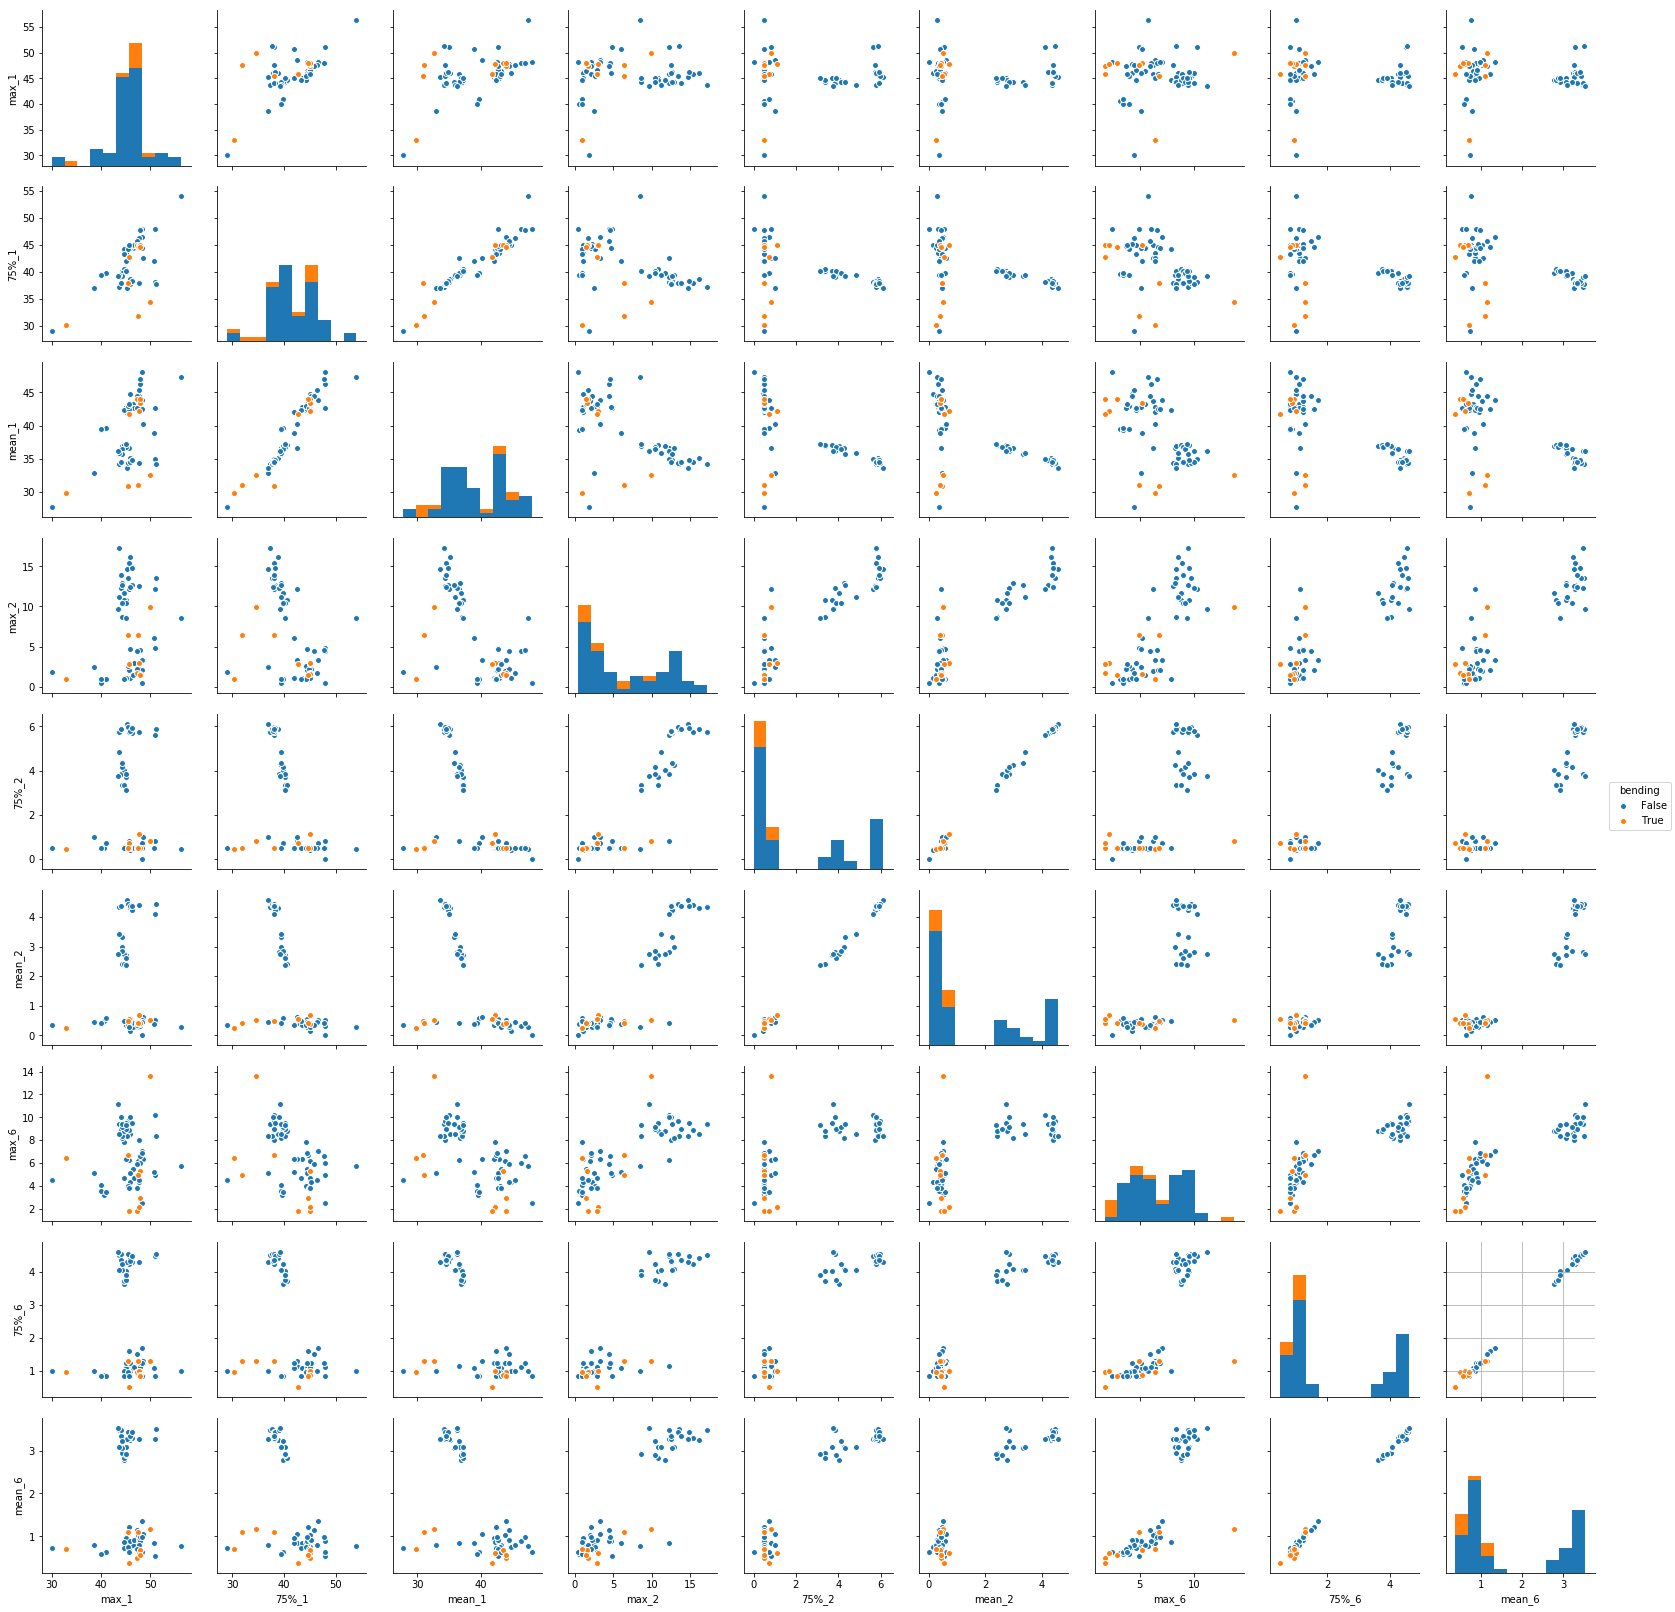

In [13]:
df3_train=di_train[['max_1','75%_1','mean_1','max_2','75%_2','mean_2','max_6','75%_6','mean_6','bending']]
sns.pairplot(df3_train,vars =['max_1','75%_1','mean_1','max_2','75%_2','mean_2','max_6','75%_6','mean_6'],hue='bending')
plt.grid()
plt.show()

### Break each time series into L, select best p

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression 

In [22]:
l_list=np.arange(1,21)

best_p=[]
best_score=0
best_model=0
score=[]
for l in l_list:
    print(l)
    df_d3=pd.DataFrame()
    file_list=[['bending1',2,7],['bending2',2,6],['cycling',3,15],['lying',3,15],['sitting',3,15],['standing',3,15],['walking',3,15]]
    for i in file_list:
        Label=i[0]
        for j in range(i[1]):
            add=i[0]+'/dataset'+str(j+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='test'
            table.append(Set)
            table.append(Label)
            df_d3=df_d3.append([table])
        for k in range(i[1],i[2]):
            add=i[0]+'/dataset'+str(k+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            
            if (i[0]=='bending2')&(k+1==4):
                add=i[0]+'/dataset'+str(k+1)+'.csv'
                data=pd.read_csv(add,skiprows=5,sep=' ',header=None,index_col=0)
                data.drop(7,axis=1,inplace=True)
                num=len(data)//l
                data_tem=data.iloc[0:num,:]
                for h in range(1,l):
                    data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
                table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='train'
            table.append(Set)
            table.append(Label)
            df_d3=df_d3.append([table])
            
    #Data processing
    df_d3=df_d3[df_d3.iloc[:,-2]=='train']
    df_d3['bending']=(df_d3.iloc[:,-1]=='bending1')|(df_d3.iloc[:,-1]=='bending2')
    #Find out the best P
    X=df_d3.iloc[:,:-3]
    Y=df_d3.iloc[:,-1]
    model=LogisticRegression(solver='liblinear',C=10**20) 
    rfe=RFECV(model,cv=5,scoring='accuracy')
    rfe.fit(X,Y)
#    score1= rfe.score(X,Y)
    score.append(cross_val_score(rfe,X,Y,cv=5,scoring='accuracy').mean())
    if best_score<score[-1]:
        best_score=score[-1]
        best_rfe=rfe
        best_X=X
        best_Y=Y
    best_p.append(len(rfe.support_[rfe.support_==True]))        
result=pd.DataFrame([l_list,best_p,score],index=['l','p','score'])

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
p,4.000000,4.000000,4.000000,4.000000,16.000000,11.000000,16.000000,3.000000,23.000000,8.000000,2.000000,6.000000,5.000000,4.000000,34.000000,7.000000,17.000000,18.000000,6.000000,12.000000
score,0.985714,0.971429,0.957143,0.971429,0.942857,0.942857,0.957143,0.942857,0.942857,0.942857,0.971429,0.957143,0.957143,0.942857,0.942857,0.956044,0.957143,0.957143,0.957143,0.957143


#### Best Pair (1,4)
For L in range(1,21), each L has best_p and its score.

Best pair is (1,4) with the score of 0.9857

## Report confusion matrix, AUC for train

In [23]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [24]:
# coefficient
best_rfe.estimator_.coef_

array([[-4.29165515,  2.54675865,  3.13672556,  3.64323171]])

Best_rfe model coefficient for 4 parameters.

array([[-4.29165515,  2.54675865,  3.13672556,  3.64323171]])

In [25]:
best_rfe.support_.reshape(6,7)

array([[False, False, False, False, False, False,  True],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False],
       [ True,  True, False, False, False,  True, False],
       [False, False, False, False, False, False, False]])

In [26]:
# get param columns loc
ind=np.where(best_rfe.support_==True)[0]
ind
#table2.iloc[0:2,ind]

array([ 6, 28, 29, 33])

Column index for best 4 parameters are [6,28,29,33]

In [27]:
best_X.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,35.00,47.40,43.954500,44.33,1.558835,43.00,45.00,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.0,1.79,0.493292,0.43,0.513506,0.00,0.94
0,33.00,47.75,42.179813,43.50,3.670666,39.15,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.0,2.18,0.613521,0.50,0.524317,0.00,1.00
0,33.00,45.75,41.678063,41.75,2.243490,41.33,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.0,1.79,0.383292,0.43,0.389164,0.00,0.50
0,37.00,48.00,43.454958,43.25,1.386098,42.50,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.00,0.0,5.26,0.679646,0.50,0.622534,0.43,0.87
0,36.25,48.00,43.969125,44.50,1.618364,43.31,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.75,0.0,2.96,0.555313,0.49,0.487826,0.00,0.83


In [28]:
# 变成array
type(best_rfe.transform(best_X))

numpy.ndarray

In [29]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2

# get p-values
X=best_X.iloc[:,ind]
Y=best_Y
scores, pvalues = chi2(X, Y)
pvalues

array([3.99688063e-01, 2.78982384e-36, 3.22181328e-12, 3.92403389e-13])

Best_rfe model p-values for 4 bet parameters are 

([3.99688063e-01, 2.78982384e-36, 3.22181328e-12, 3.92403389e-13])

In [30]:
#model=LogisticRegression(solver='liblinear') 
y_train_pred=best_rfe.estimator_.predict(best_rfe.transform(best_X))
confusion_matrix(best_Y, y_train_pred)

array([[60,  0],
       [ 0,  9]])

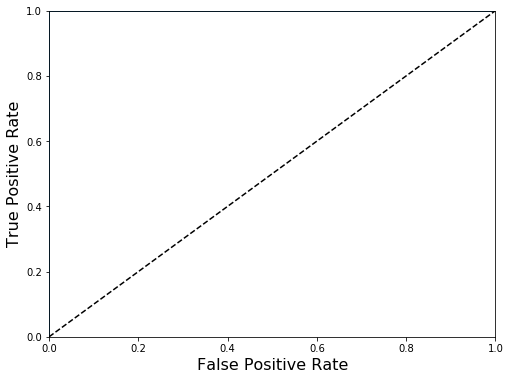

In [31]:
from sklearn.metrics import roc_curve
y_scores =best_rfe.estimator_.decision_function(best_rfe.transform(best_X))
fpr, tpr, thresholds = roc_curve(best_Y, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [32]:
# Area under curve
from sklearn.metrics import roc_auc_score
roc_auc_score(best_Y, y_scores)

1.0

Auc = 1

## Report on test set

In [33]:
# prepare test set
di_test['bending']=(di_test['class']=='bending1')|(di_test['class']=='bending2')
di_test.tail(10)


di_test

/Users/jialinshi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,min_1,max_1,mean_1,median_1,std_1,25%_1,75%_1,min_2,max_2,mean_2,...,min_6,max_6,mean_6,median_6,std_6,25%_6,75%_6,set,class,bending
46,19.33,43.50,34.227771,35.500,4.889576,30.5000,37.7500,0.0,14.50,3.995729,...,0.0,9.74,3.394125,3.100,1.792090,2.105,4.425,test,walking,False
47,12.50,45.00,33.509729,34.125,4.850923,30.5000,36.7500,0.0,13.05,4.450771,...,0.0,8.96,3.378479,3.085,1.787360,2.060,4.440,test,walking,False
48,15.00,46.75,34.660583,35.000,5.315110,31.0000,38.2500,0.0,13.44,4.200896,...,0.0,8.99,3.244396,3.000,1.630983,2.120,4.240,test,walking,False
61,24.25,45.00,37.177042,36.250,3.581301,34.5000,40.2500,0.0,8.58,2.374208,...,0.0,9.34,2.921729,2.500,1.852600,1.500,3.900,test,cycling,False
62,28.75,44.75,37.561188,36.875,3.226507,35.2500,40.2500,0.0,9.91,2.080688,...,0.0,9.62,2.765896,2.450,1.769203,1.410,3.770,test,cycling,False
63,22.00,44.67,37.058708,36.000,3.710180,34.5000,40.0625,0.0,14.17,2.438146,...,0.0,8.55,2.983750,2.570,1.815730,1.500,4.150,test,cycling,False
76,37.25,45.00,40.624792,40.500,1.476967,39.2500,42.0000,0.0,1.30,0.358604,...,0.0,1.92,0.570583,0.430,0.582915,0.000,1.300,test,bending1,True
77,38.00,45.67,42.812812,42.500,1.435550,42.0000,43.6700,0.0,1.22,0.372438,...,0.0,3.11,0.571083,0.430,0.601010,0.000,1.300,test,bending1,True
83,12.75,51.00,24.562958,24.250,3.737514,23.1875,26.5000,0.0,6.87,0.590833,...,0.0,4.97,0.700188,0.500,0.693720,0.430,0.870,test,bending2,True
84,0.00,42.75,27.464604,28.000,3.583582,25.5000,30.0000,0.0,7.76,0.449708,...,0.0,6.76,1.122125,0.830,1.012342,0.470,1.300,test,bending2,True


##### prepare model

In [35]:
# fit train data

# lgrg=LogisticRegression(solver='liblinear') 
# X_train=best_X.iloc[:,ind]
# Y_train=best_Y
X_test= di_test.iloc[:,ind]
Y_test= di_test.iloc[:,-1]
best_rfe.estimator_.score(X_test,Y_test)


1.0

Previous cross validation accuracy =0.9857, 

Test_score =1

## Check for class imbalance

In [36]:
predictions = y_train_pred=best_rfe.estimator_.predict(X_test)
confusion_matrix(Y_test, predictions)

array([[15,  0],
       [ 0,  4]])

Yes. Use statmodel to fit it will warn perfect separation and if draw a scatter plot, the data points are separated. 

It seem to be well-separated to cause instability in calculating logistic regression parameters

## Resample to remedy class imbalance

In [37]:
from sklearn.utils import resample

In [38]:
dfnew=pd.concat([best_X,best_Y],axis=1)
len(dfnew)

69

In [39]:
# prepare train set with 4 parameters and class label
d7train=dfnew.iloc[:,:]

# split majority and minority in the train set
d7train_minor=d7train[d7train['bending']==True]
d7train_major=d7train[d7train['bending']==False]

#upsample minor
minor_up=resample(d7train_minor,replace= True, n_samples=60,random_state =123)

#concat minor and major
d7up = pd.concat([d7train_major,minor_up])
d7up.tail()


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,bending
0,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.43,0.389164,0.0,0.50,True
0,36.25,48.00,43.969125,44.50,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555313,0.49,0.487826,0.0,0.83,True
0,25.00,47.50,31.058250,29.71,4.829794,27.50,31.8125,0.0,6.38,0.405458,...,9.0000,18.3125,0.0,4.92,1.098104,0.94,0.831480,0.5,1.30,True
0,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.50,0.524317,0.0,1.00,True
0,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.43,0.389164,0.0,0.50,True


In [40]:
# build a new model with upscaling data
l=1
best_p=[]
best_score=0
best_model=0
score=[]

X=d7up.iloc[:,:-3]
Y=d7up.iloc[:,-1]

model=LogisticRegression(solver='liblinear',C=10**20) 
rfe2=RFECV(model,cv=5,scoring='accuracy')
rfe2.fit(X,Y)
#score2= rfe2.score(X,Y)
score.append(cross_val_score(rfe2,X,Y,cv=5,scoring='accuracy').mean())
#score.append(score2)
if best_score<score[-1]:
    best_score=score[-1]
    best_rfe2=rfe2
    best_X2=X
    best_Y2=Y
best_p.append(len(rfe2.support_[rfe2.support_==True]))
result=pd.DataFrame([l,best_p,score],index=['l','p','score'])
result

,0
l,1
p,[4]
score,[0.9583333333333333]


In [41]:
ind=np.where(best_rfe2.support_==True)[0]
X=d7up.iloc[:,ind]
Y=d7up.iloc[:,-1]

In [42]:
#model=LogisticRegression(solver='liblinear') 
y_train_pred=best_rfe2.estimator_.predict(best_rfe2.transform(best_X2))
confusion_matrix(best_Y2, y_train_pred)

array([[60,  0],
       [ 0, 60]])

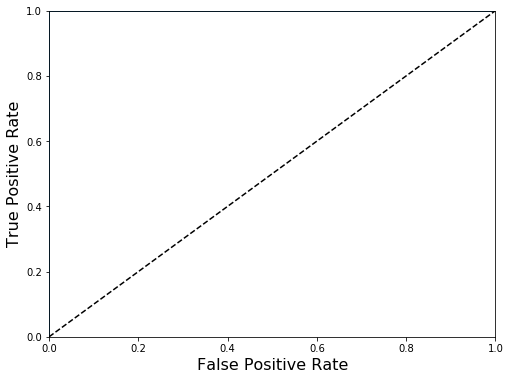

In [43]:
y_scores=best_rfe2.estimator_.decision_function(best_rfe2.transform(best_X2))
fpr, tpr, thresholds = roc_curve(best_Y2, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [44]:
# Area under curve
from sklearn.metrics import roc_auc_score
roc_auc_score(best_Y2, y_scores)

1.0

Since the dataset is quite small, I use upsampling to replicate minor class.

Use upsampled data to build a new model, for L=1, best p is still 4. Auc=1. Score=1.

## Binary Classificaion using L1-penalized Logistic Regression

In [96]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale 
from sklearn import preprocessing

In [144]:
l_list=np.arange(1,21)
C=[]
best_p=[]
best_score=0
best_model=0
score=[]
for l in l_list:
    print(l)
    df_de=pd.DataFrame()
    file_list=[['bending1',2,7],['bending2',2,6],['cycling',3,15],['lying',3,15],['sitting',3,15],['standing',3,15],['walking',3,15]]
    for i in file_list:
        Label=i[0]
        for j in range(i[1]):
            add=i[0]+'/dataset'+str(j+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='test'
            table.append(Set)
            table.append(Label)
            df_de=df_de.append([table])
        for k in range(i[1],i[2]):
            add=i[0]+'/dataset'+str(k+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            
            if (i[0]=='bending2')&(k+1==4):
                add=i[0]+'/dataset'+str(k+1)+'.csv'
                data=pd.read_csv(add,skiprows=5,sep=' ',header=None,index_col=0)
                data.drop(7,axis=1,inplace=True)
                num=len(data)//l
                data_tem=data.iloc[0:num,:]
                for h in range(1,l):
                    data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
                table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='train'
            table.append(Set)
            table.append(Label)
            df_de=df_de.append([table])
           
    #Data processing
    df_de_train=df_de[df_de.iloc[:,-2]=='train']
    df_de_test=df_de[df_de.iloc[:,-2]=='test']
    
    df_de_train['bending']=(df_de_train.iloc[:,-1]=='bending1')|(df_de_train.iloc[:,-1]=='bending2')
    df_de_test['bending']=(df_de_test.iloc[:,-1]=='bending1')|(df_de_test.iloc[:,-1]=='bending2')
    
    #Find out the best P
    X=df_de_train.iloc[:,:-3]
    Y=df_de_train.iloc[:,-1]
    Xt=df_de_test.iloc[:,:-3]
    Yt=df_de_test.iloc[:,-1]
    
    # normalized data
    X=scale(X)
    Xt=scale(Xt)

    # build a model
    model=LogisticRegressionCV(cv=5,solver='liblinear',penalty='l1') 
    model.fit(X,Y)
    ms=model.scores_[1]
    high=max(ms.mean(axis=0))
    score.append(high)
    C.append(model.C_)
    if best_score<score[-1]:
        best_score=score[-1]
        best_model=model
        best_X=X
        best_Y=Y
        best_test=Xt    
        testY=Yt
result=pd.DataFrame([l_list,C,score],index=['l','C','score'])


result

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
C,[0.3593813663804626],[0.3593813663804626],[0.3593813663804626],[0.3593813663804626],[2.782559402207126],[0.3593813663804626],[0.3593813663804626],[0.3593813663804626],[2.782559402207126],[166.81005372000558],[2.782559402207126],[2.782559402207126],[0.3593813663804626],[0.3593813663804626],[2.782559402207126],[0.3593813663804626],[21.54434690031882],[0.3593813663804626],[0.3593813663804626],[21.54434690031882]
score,0.971429,0.957143,0.971429,0.957143,0.941758,0.957143,0.941758,0.941758,0.941758,0.957143,0.957143,0.957143,0.942857,0.942857,0.941758,0.927473,0.942857,0.957143,0.957143,0.942857


For L1-penalized model, normalized the data.

## Compare

In [145]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = best_model.predict(best_X)
confusion_matrix(best_Y, y_train_pred)

array([[60,  0],
       [ 1,  8]])

In [146]:
# get test score for L1 penalty
best_model.score(best_test,testY)

0.8947368421052632

 Variable selection model has the test score = 1.
 
 L1-penalized model has the test score =0.894. Best L = 1
 
 Therefore Variable selection model performs better. 
 
 L1-penalized model needs to normalize data since it is very sensitive to scale.
 Variable selection modele is not influenced a lot by scale.
 Technically L1 is easier to implement since it doesn't need use cross-validation twice and compute faster..   

## Multi-class Classification

In [149]:
l_list=np.arange(1,21)
C=[]
best_p=[]
best_score=0
best_model=0
score=[]
for l in l_list:
    print(l)
    df_f=pd.DataFrame()
    file_list=[['bending1',2,7],['bending2',2,6],['cycling',3,15],['lying',3,15],['sitting',3,15],['standing',3,15],['walking',3,15]]
    for i in file_list:
        Label=i[0]
        for j in range(i[1]):
            add=i[0]+'/dataset'+str(j+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='test'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
        for k in range(i[1],i[2]):
            add=i[0]+'/dataset'+str(k+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            if (i[0]=='bending2')&(k+1==4):
                add=i[0]+'/dataset'+str(k+1)+'.csv'
                data=pd.read_csv(add,skiprows=5,sep=' ',header=None,index_col=0)
                data.drop(7,axis=1,inplace=True)
                num=len(data)//l
                data_tem=data.iloc[0:num,:]
                for h in range(1,l):
                    data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
                table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='train'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
            
    #Data processing
    df_f.replace({'bending1':'bending','bending2':'bending'},inplace=True)
    df_f_train=df_f[df_f.iloc[:,-2]=='train']
    df_f_test=df_f[df_f.iloc[:,-2]=='test']
    
    #Find out the best P
    X=df_f_train.iloc[:,:-2]
    Y=df_f_train.iloc[:,-1]
    Xt=df_f_test.iloc[:,:-2]
    Yt=df_f_test.iloc[:,-1]
    
    # normalized data
    X=scale(X)
    Xt=scale(Xt)
    
    # build model
    model=LogisticRegressionCV(cv=5,solver='saga',penalty='l1',multi_class='multinomial') 
    model.fit(X,Y)
    score.append(model.score(X,Y))
    C.append(model.C_)
    if best_score<score[-1]:
        best_score=score[-1]
        best_model=model
        best_X=X
        best_Y=Y
        best_test=Xt
        testY=Yt
result=pd.DataFrame([l_list,C,score],index=['l','C','score'])

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
C,"[2.782559402207126, 2.782559402207126, 2.78255...","[10000.0, 10000.0, 10000.0, 10000.0, 10000.0, ...","[2.782559402207126, 2.782559402207126, 2.78255...","[1291.5496650148827, 1291.5496650148827, 1291....","[166.81005372000558, 166.81005372000558, 166.8...","[0.3593813663804626, 0.3593813663804626, 0.359...","[1291.5496650148827, 1291.5496650148827, 1291....","[166.81005372000558, 166.81005372000558, 166.8...","[21.54434690031882, 21.54434690031882, 21.5443...","[21.54434690031882, 21.54434690031882, 21.5443...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359...","[21.54434690031882, 21.54434690031882, 21.5443...","[166.81005372000558, 166.81005372000558, 166.8...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359...","[0.3593813663804626, 0.3593813663804626, 0.359..."
score,0.985507,1,1,1,1,0.971014,1,1,1,1,0.985507,1,1,1,1,1,0.985507,1,1,1


In [150]:
y_train_pred = best_model.predict(best_X)
confusion_matrix(best_Y, y_train_pred)

array([[ 9,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0, 12]])

In [151]:
# get test score
best_model.score(best_test,testY)

0.8421052631578947

-------(F-i)--------

For multinomial task, the model score = 0.84， best L = 2

#### research on how confusion matrices and ROC curves are defined for multiclass classification
The best answer could be to treat the multiclass as a binary classification problem that is consider one vs all and calculate the operating points for each class and then average it out for the entire classifier. 

## GaussianNB 

In [126]:
from sklearn.naive_bayes import GaussianNB

In [128]:
l_list=np.arange(1,21)
best_p=[]
best_score=0
best_model=0
score=[]
for l in l_list:
    print(l)
    df_f=pd.DataFrame()
    file_list=[['bending1',2,7],['bending2',2,6],['cycling',3,15],['lying',3,15],['sitting',3,15],['standing',3,15],['walking',3,15]]
    for i in file_list:
        Label=i[0]
        for j in range(i[1]):
            add=i[0]+'/dataset'+str(j+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='test'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
        for k in range(i[1],i[2]):
            add=i[0]+'/dataset'+str(k+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            if (i[0]=='bending2')&(k+1==4):
                add=i[0]+'/dataset'+str(k+1)+'.csv'
                data=pd.read_csv(add,skiprows=5,sep=' ',header=None,index_col=0)
                data.drop(7,axis=1,inplace=True)
                num=len(data)//l
                data_tem=data.iloc[0:num,:]
                for h in range(1,l):
                    data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
                table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='train'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
            
    #Data processing
    df_f_train=df_f[df_f.iloc[:,-2]=='train']
    df_f_test=df_f[df_f.iloc[:,-2]=='test']
    #Find out the best P
    X=df_f_train.iloc[:,:-2]
    Y=df_f_train.iloc[:,-1]
    model=GaussianNB()
    model.fit(X,Y)
    score.append(model.score(X,Y))
    if best_score<score[-1]:
        best_score=score[-1]
        best_model=model
        best_X=X
        best_Y=Y
        best_test=df_f_test
result=pd.DataFrame([l_list,score],index=['l','score'])

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l,1.0,2.0,3.000000,4.0,5.000000,6.000000,7.0,8.000000,9.0,10.0,11.000000,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0
score,1.0,1.0,0.985507,1.0,0.985507,0.971014,1.0,0.985507,1.0,1.0,0.985507,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [129]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = best_model.predict(best_X)
confusion_matrix(best_Y, y_train_pred)

array([[ 5,  0,  0,  0,  0,  0,  0],
       [ 0,  4,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0],
       [ 0,  0,  0,  0,  0, 12,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [130]:
best_model.score(best_test.iloc[:,:-2], best_test.iloc[:,-1])

0.8947368421052632

For GaussianNB, the model score=0.895,   best L = 1

## multinomial

In [131]:
from sklearn.naive_bayes import MultinomialNB

In [133]:
l_list=np.arange(1,21)
best_p=[]
best_score=0
best_model=0
score=[]
for l in l_list:
    print(l)
    df_f=pd.DataFrame()
    file_list=[['bending1',2,7],['bending2',2,6],['cycling',3,15],['lying',3,15],['sitting',3,15],['standing',3,15],['walking',3,15]]
    for i in file_list:
        Label=i[0]
        for j in range(i[1]):
            add=i[0]+'/dataset'+str(j+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='test'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
        for k in range(i[1],i[2]):
            add=i[0]+'/dataset'+str(k+1)+'.csv'
            data=pd.read_csv(add,skiprows=4,index_col=0)
            num=len(data)//l
            data_tem=data.iloc[0:num,:]
            for h in range(1,l):
                data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
            table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            if (i[0]=='bending2')&(k+1==4):
                add=i[0]+'/dataset'+str(k+1)+'.csv'
                data=pd.read_csv(add,skiprows=5,sep=' ',header=None,index_col=0)
                data.drop(7,axis=1,inplace=True)
                num=len(data)//l
                data_tem=data.iloc[0:num,:]
                for h in range(1,l):
                    data_tem=np.c_[data_tem,data.iloc[num*h:num*(h+1),:]]
                table=pd.DataFrame(data_tem).describe().T.iloc[:,[3,-1,1,-3,2,-4,-2]].values.reshape(1,-1)[0].tolist()
            Set='train'
            table.append(Set)
            table.append(Label)
            df_f=df_f.append([table])
            
    #Data processing
    df_f_train=df_f[df_f.iloc[:,-2]=='train']
    df_f_test=df_f[df_f.iloc[:,-2]=='test']
    #Find out the best P
    X=df_f_train.iloc[:,:-2]
    Y=df_f_train.iloc[:,-1]
    model=MultinomialNB()
    model.fit(X,Y)
    score.append(model.score(X,Y))
    if best_score<score[-1]:
        best_score=score[-1]
        best_model=model
        best_X=X
        best_Y=Y
        best_test=df_f_test
result=pd.DataFrame([l_list,score],index=['l','score'])

result

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
l,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000,14.000000,15.000000,16.000000,17.000000,18.000000,19.000000,20.000000
score,0.927536,0.884058,0.898551,0.913043,0.927536,0.956522,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029,0.942029


In [134]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = best_model.predict(best_X)
confusion_matrix(best_Y, y_train_pred)

array([[ 5,  0,  0,  0,  0,  0,  0],
       [ 1,  3,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0],
       [ 0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  1, 11,  0,  0],
       [ 0,  0,  0,  0,  1, 11,  0],
       [ 0,  0,  0,  0,  0,  0, 12]])

In [135]:
best_model.score(best_test.iloc[:,:-2], best_test.iloc[:,-1])

0.7368421052631579

Gaussian score = 0.895，   Best L =1

Multinomial score = 0.737,  Best L =6

Hence, Gaussian has a better score than Multinomial.